In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Flatten, Dense, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Dropout, Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.data import AUTOTUNE
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation

import matplotlib.pyplot as plt

import os
from pathlib import Path

In [ ]:
RANDOM_SEED=4
# BASE_PATH = os.path.join(Path(os.getcwd()).resolve().parents[1], "Data")
BASE_PATH = os.path.join(os.getcwd(), "Data")
assert os.path.isdir(BASE_PATH), f'Data Directory is required: {BASE_PATH}'
BATCH_SIZE = 1024
EPOCHS = 100
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])

tf.random.set_seed(RANDOM_SEED)

In [ ]:
train_data = image_dataset_from_directory(TRAIN_PATH, image_size=(50,50), label_mode='binary',
                                  seed=RANDOM_SEED, shuffle=True, batch_size=BATCH_SIZE)
val_data = image_dataset_from_directory(VAL_PATH, image_size=(50,50), label_mode='binary',
                                  seed=RANDOM_SEED, shuffle=True, batch_size=BATCH_SIZE)
test_data = image_dataset_from_directory(TEST_PATH, image_size=(50,50), label_mode='binary',
                                  seed=RANDOM_SEED, shuffle=True, batch_size=BATCH_SIZE)

Found 176794 files belonging to 2 classes.
Found 49334 files belonging to 2 classes.
Found 51396 files belonging to 2 classes.


In [ ]:
# data_augmentation = Sequential([
#         RandomFlip("horizontal_and_vertical", input_shape=(50, 50, 3)),
#         RandomRotation(0.2),
#         RandomZoom(0.3),
#         RandomTranslation(height_factor=0.2, width_factor=0.2),
#         Rescaling(1./255),
# ])


In [ ]:
# Create an EfficientNetB0 model
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(50, 50, 3))

# # Freeze the first half of the layers
# for layer in base_model.layers[:-20]:
#     layer.trainable = False

# Define additional layers
additional_layers = Sequential([
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

# Combine base model with additional layers
model = Sequential([
    base_model,
    additional_layers
])

# Print model summary
model.summary()


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 2, 2, 1280)        4049571   
 )                                                               
                                                                 
 sequential_30 (Sequential)  (None, 1)                 1281      
                                                                 
Total params: 4050852 (15.45 MB)
Trainable params: 4008829 (15.29 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [ ]:
# Get the last layer of the model
last_layer = model.layers[-2]

# Get the output shape of the last layer
last_layer_output_shape = last_layer.output_shape

print("Last layer output shape:", last_layer_output_shape)

Last layer output shape: (None, 2, 2, 1280)


In [ ]:
whole_system = Sequential([
    # data_augmentation,
    model
])

whole_system.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_31 (Sequential)  (None, 1)                 4050852   
                                                                 
Total params: 4050852 (15.45 MB)
Trainable params: 4008829 (15.29 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [ ]:
checkpoint_dir = 'EffecientB0_Models'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_filepath = os.path.join(checkpoint_dir, 'checkpoint.model2.keras')

# Define the ModelCheckpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

# Define the EarlyStopping callback
limited_computation_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)

In [ ]:
whole_system.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy(),
                tf.keras.metrics.F1Score(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.Precision()])

In [ ]:
history = whole_system.fit(train_data, epochs=EPOCHS, validation_data=val_data,
                batch_size=BATCH_SIZE, callbacks=[model_checkpoint_callback,
                                                limited_computation_callback],
                class_weight={
                0: 1/0.7, # weight for the majority class (inversely proportional to its frequency)
                1: 1/0.3}  # weight for the minority class (inversely proportional to its frequency)
                )

Epoch 1/100
1382/1382 [==============================] - 182s 106ms/step - loss: 0.5151 - binary_accuracy: 0.8905 - f1_score: 0.4462 - recall_8: 0.8969 - precision_8: 0.7633 - val_loss: 0.2942 - val_binary_accuracy: 0.8781 - val_f1_score: 0.4902 - val_recall_8: 0.8294 - val_precision_8: 0.8005
Epoch 2/100
1382/1382 [==============================] - 144s 104ms/step - loss: 0.4656 - binary_accuracy: 0.9000 - f1_score: 0.4462 - recall_8: 0.9109 - precision_8: 0.7785 - val_loss: 0.3094 - val_binary_accuracy: 0.8736 - val_f1_score: 0.4894 - val_recall_8: 0.8458 - val_precision_8: 0.7811
Epoch 3/100
1382/1382 [==============================] - 144s 104ms/step - loss: 0.4194 - binary_accuracy: 0.9098 - f1_score: 0.4462 - recall_8: 0.9230 - precision_8: 0.7955 - val_loss: 0.3282 - val_binary_accuracy: 0.8701 - val_f1_score: 0.4884 - val_recall_8: 0.7194 - val_precision_8: 0.8555
Epoch 4/100
1382/1382 [==============================] - 143s 104ms/step - loss: 0.3766 - binary_accuracy: 0.9184 -

In [ ]:
whole_system.evaluate(test_data)

402/402 [==============================] - 16s 39ms/step - loss: 0.3859 - binary_accuracy: 0.8722 - f1_score: 0.3810 - recall_8: 0.7513 - precision_8: 0.7180


[0.38590145111083984,
 0.8721885085105896,
 array([0.38095388], dtype=float32),
 0.7513450980186462,
 0.7180034518241882]

In [ ]:
whole_system.save("effecientb0_classweight.keras")


In [ ]:
history.history

{'loss': [0.5151464939117432,
  0.4656142294406891,
  0.41942158341407776,
  0.3766302168369293,
  0.3324327766895294,
  0.2932676374912262],
 'binary_accuracy': [0.890522301197052,
  0.8999796509742737,
  0.909770667552948,
  0.9183852672576904,
  0.9273504614830017,
  0.9362365007400513],
 'f1_score': [array([0.4462122], dtype=float32),
  array([0.44616318], dtype=float32),
  array([0.44616908], dtype=float32),
  array([0.44616318], dtype=float32),
  array([0.44616318], dtype=float32),
  array([0.446171], dtype=float32)],
 'recall_8': [0.8968560099601746,
  0.9109014272689819,
  0.9229769110679626,
  0.9346190094947815,
  0.9449806809425354,
  0.9525057077407837],
 'precision_8': [0.7632907032966614,
  0.7784548997879028,
  0.7955378890037537,
  0.8102638721466064,
  0.8267726302146912,
  0.8451105356216431],
 'val_loss': [0.2941778898239136,
  0.3093613088130951,
  0.3282341957092285,
  0.3558371365070343,
  0.3796756863594055,
  0.410169392824173],
 'val_binary_accuracy': [0.878075

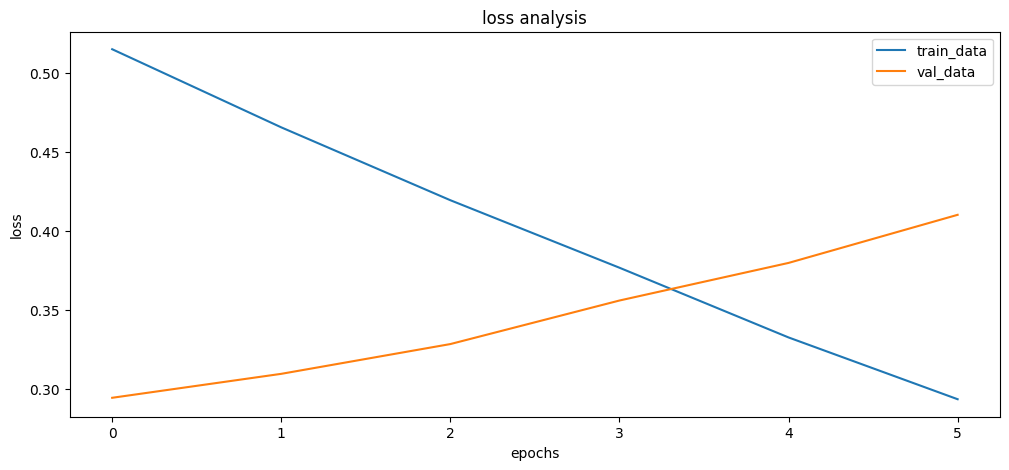

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_data','val_data'])
plt.title('loss analysis')
plt.show()

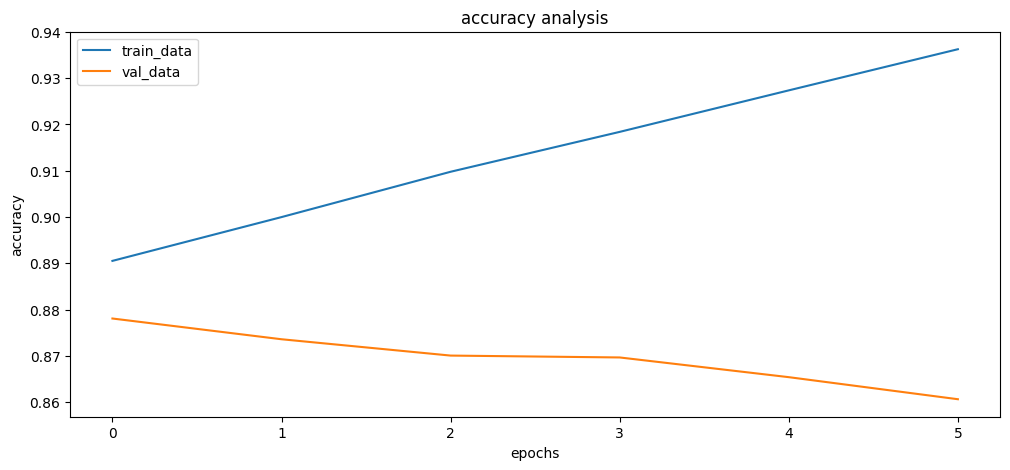

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_data','val_data'])
plt.title('accuracy analysis')
plt.show()

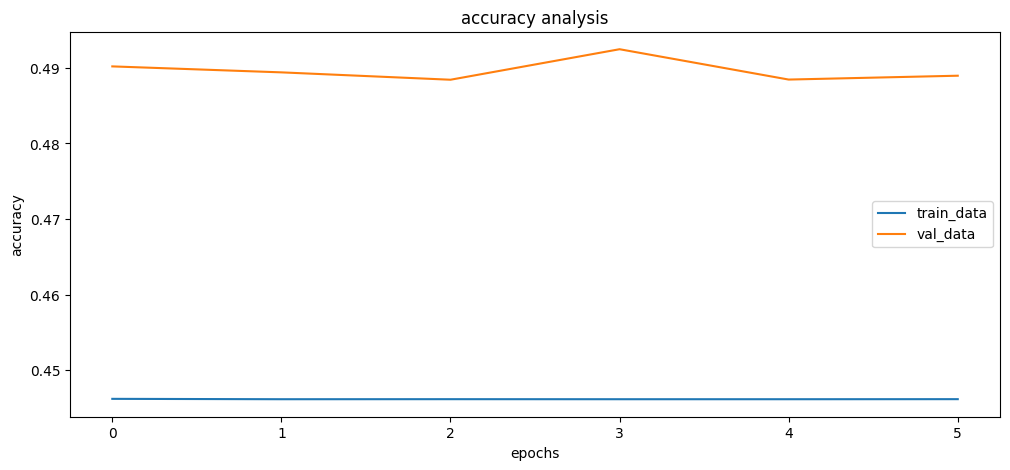

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_data','val_data'])
plt.title('accuracy analysis')
plt.show()

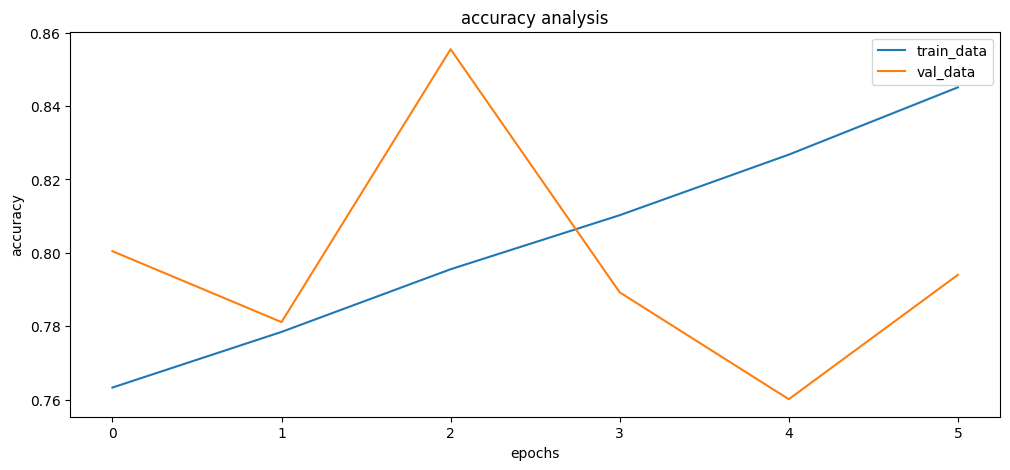

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(history.history['precision_8'])
plt.plot(history.history['val_precision_8'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_data','val_data'])
plt.title('accuracy analysis')
plt.show()

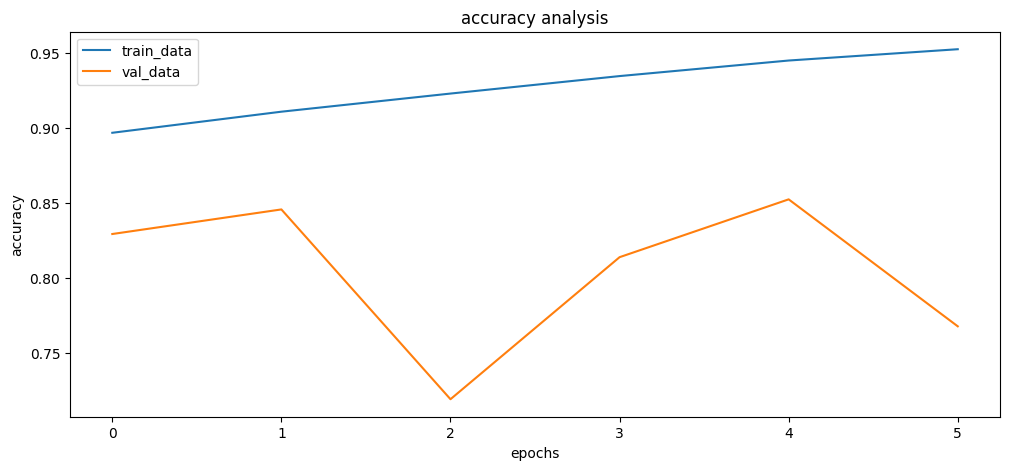

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(history.history['recall_8'])
plt.plot(history.history['val_recall_8'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_data','val_data'])
plt.title('accuracy analysis')
plt.show()